In [54]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(os.path.dirname('__file__'), '../'))

import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import random
from jax_cltv.datasets.dummy import DummySubscriptions
from jax_cltv.models.mle import MLE
from jax_cltv.dists.normal import rv_samples as normal_rv_samples
from jax_cltv.dists.geom import Geometric, neg_loglikelihood
from jax_cltv.plots.plot_data import plot_churns, plot_survives
from jax_cltv.utils.ltv import calc_ltv
from sklearn.model_selection import train_test_split

plt.style.use('ggplot')

In [2]:
def init_variables(to_delete: list) -> None:
    for v in to_delete:
        try: 
            del v
        except:
            pass

In [3]:
theta_true_1 = 0.7
theta_true_2 = 0.1

ds1, data1 = DummySubscriptions(p=theta_true_1, size=800)()
ds2, data2 = DummySubscriptions(p=theta_true_2, size=200)()

In [4]:
df1 = ds1.to_pandas()
df1['segment'] = 'A'
df2 = ds2.to_pandas()
df2['segment'] = 'B'

df = pd.concat([df2, df1], ignore_index=True)
df = df.fillna(0)

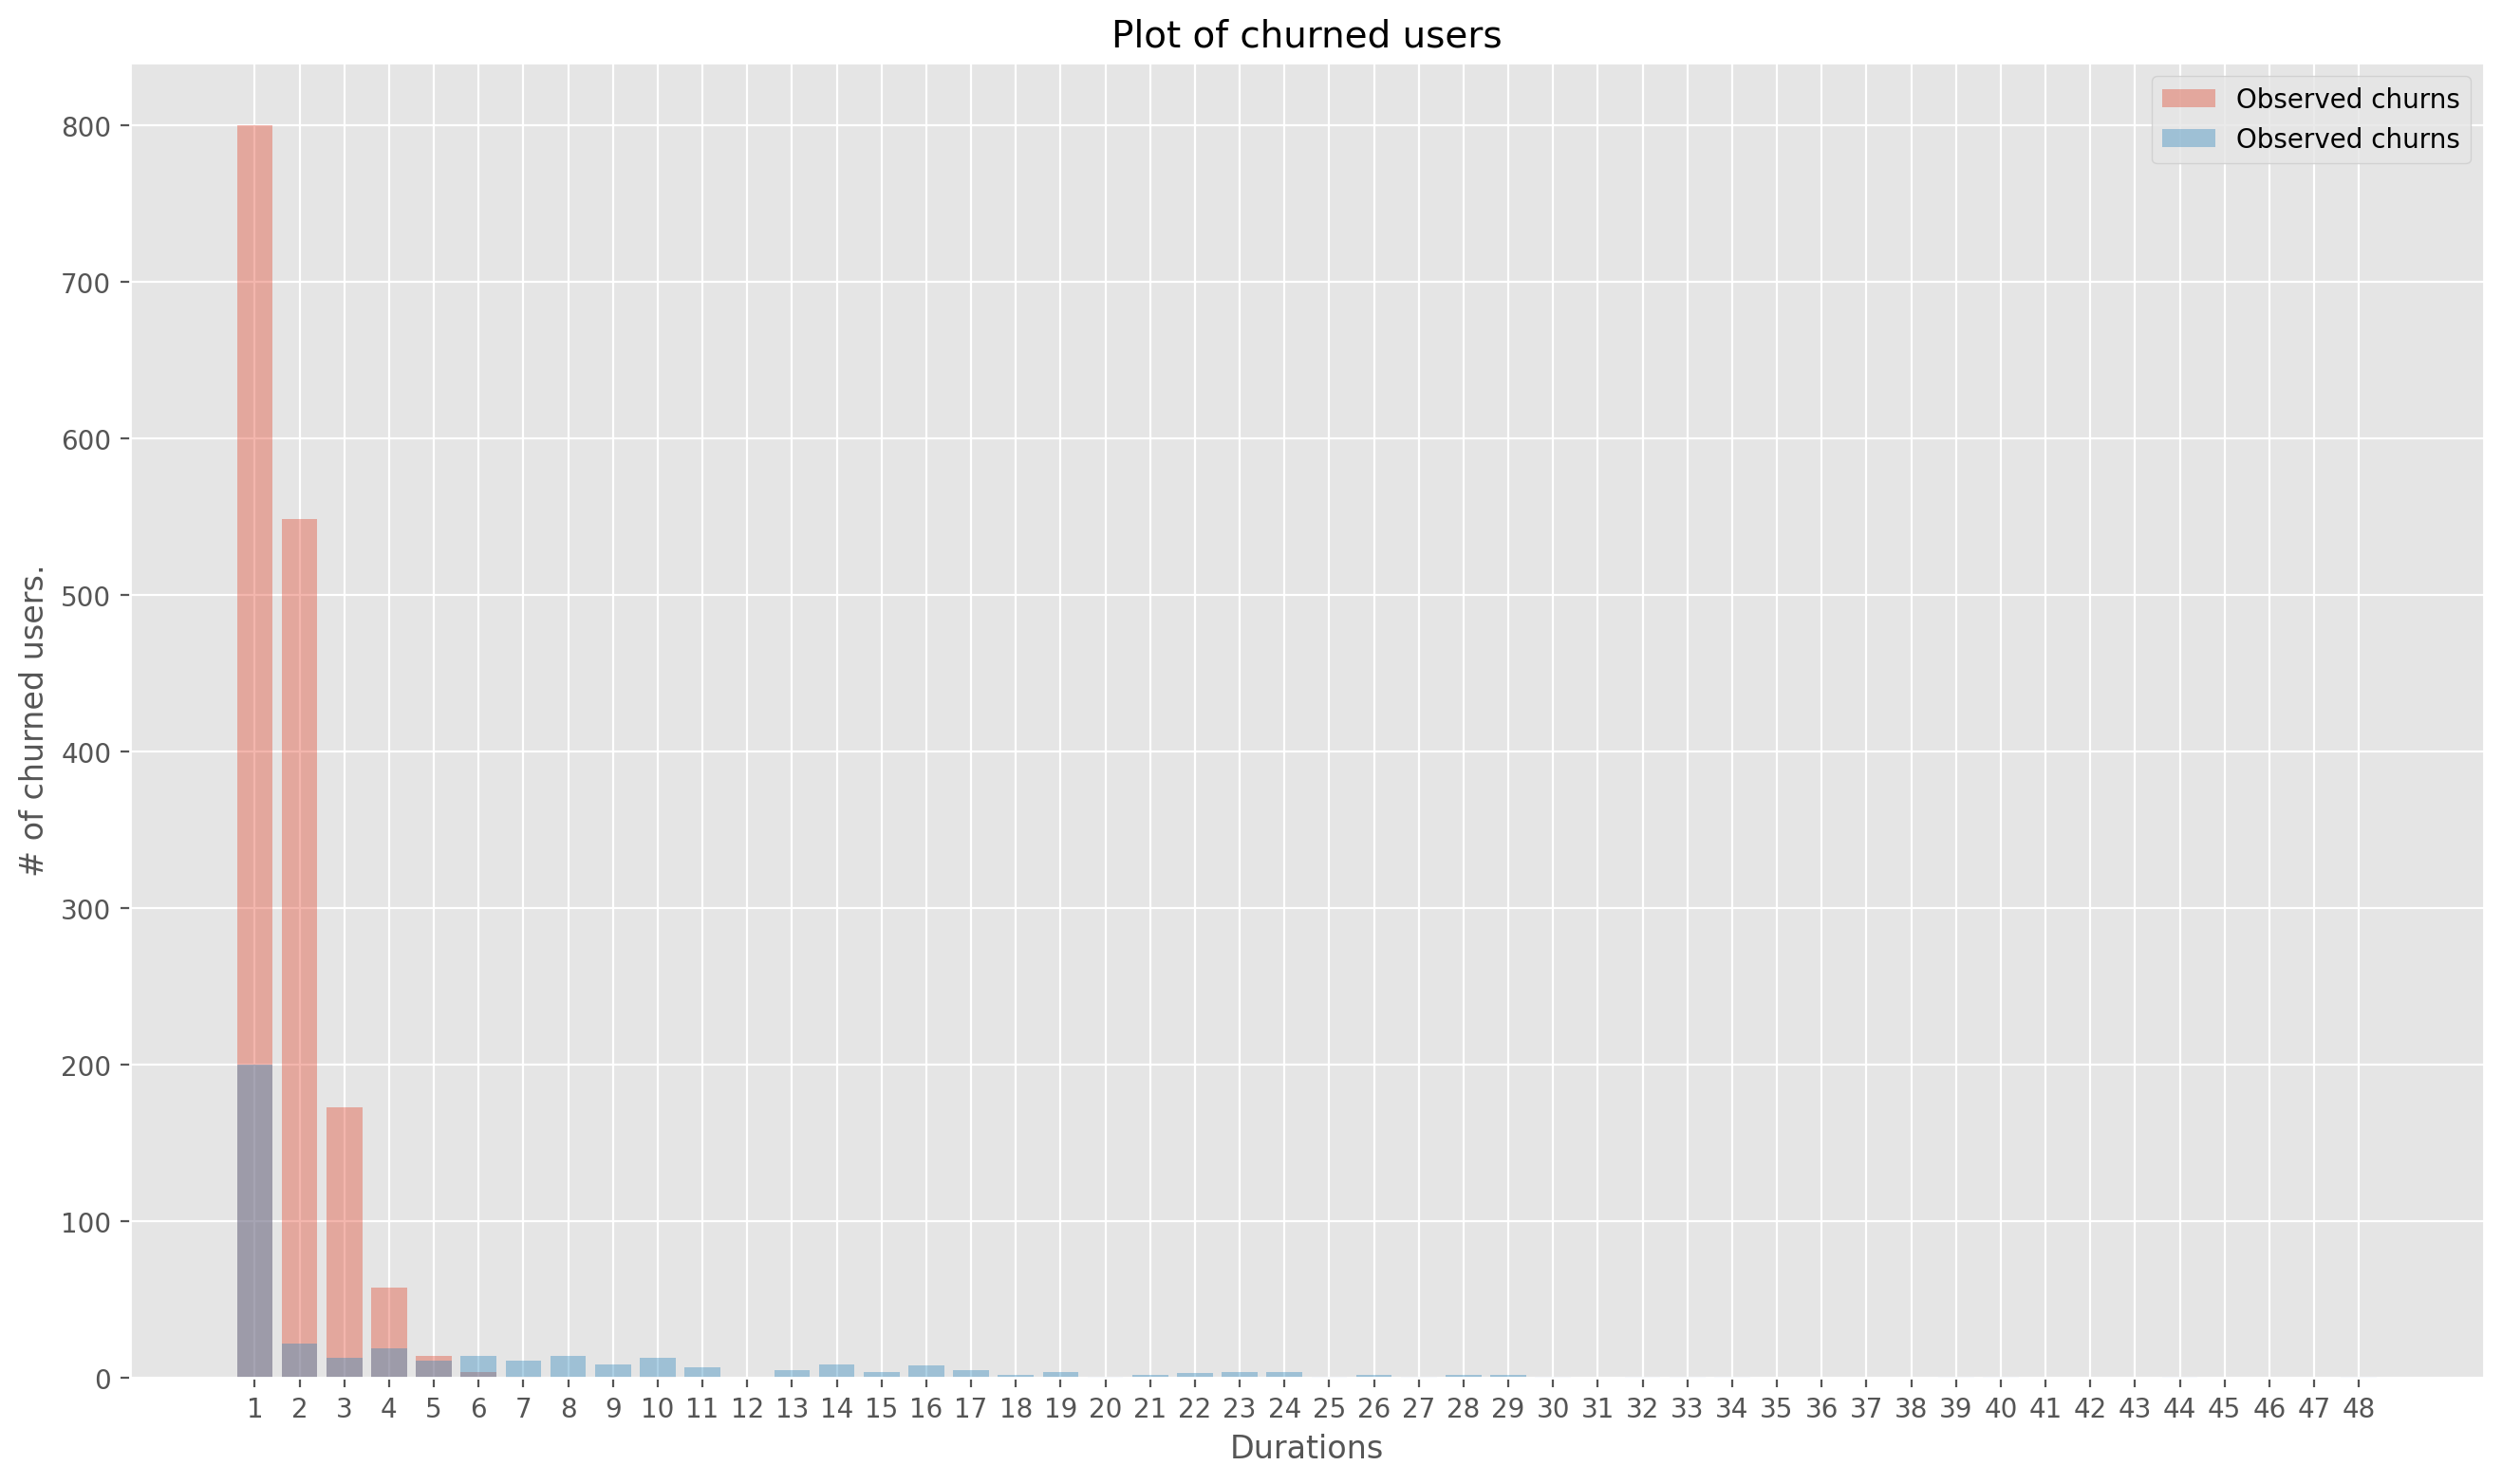

In [13]:
ax = plot_churns(df[df['segment']=='A'].iloc[:, :-1], yscale='linear', kind='bar', density=False)
ax = plot_churns(df[df['segment']=='B'].iloc[:, :-1], yscale='linear', kind='bar', density=False, ax=ax)
plt.show()

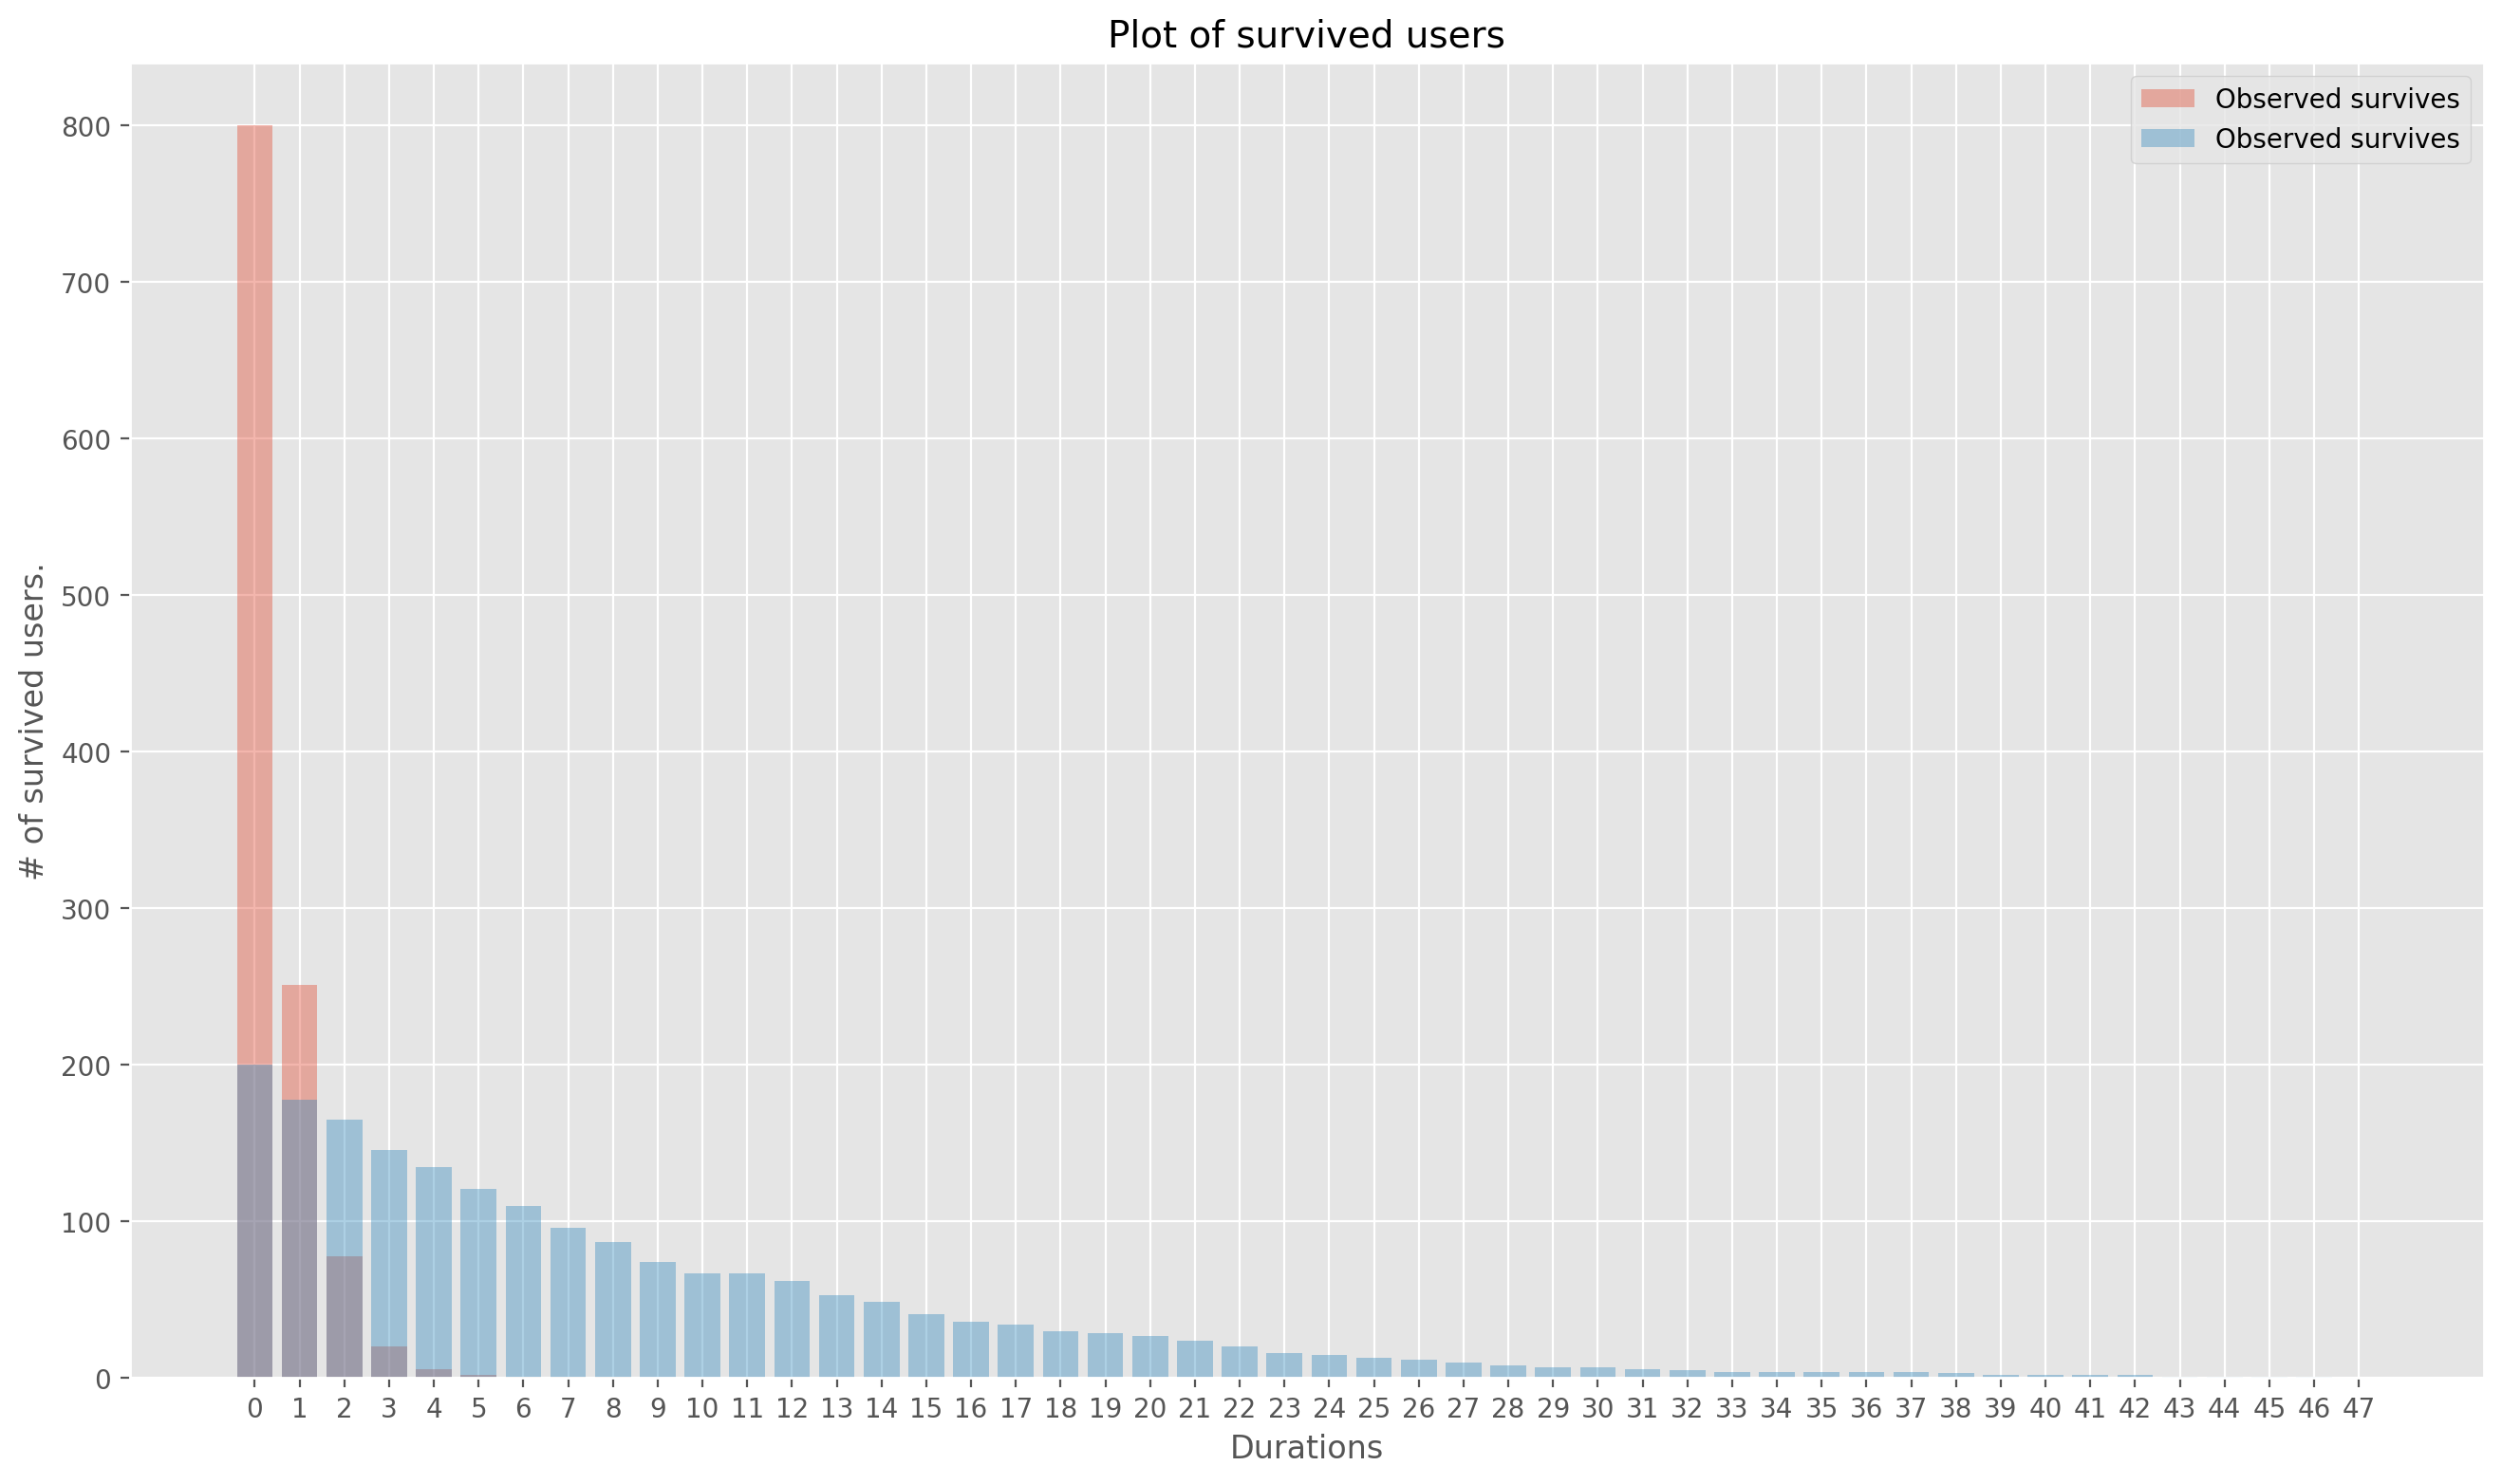

In [14]:
ax = plot_survives(df[df['segment']=='A'].iloc[:, :-1], yscale='linear', density=False)
ax = plot_survives(df[df['segment']=='B'].iloc[:, :-1], yscale='linear', density=False, ax=ax)
plt.show()

## Bayesian inference with PyMC4

In [15]:
import arviz as az
import pymc as pm

az.style.use("arviz-darkgrid")

In [10]:
print(f'Running on pymc version: {pm.__version__}')

Running on pymc version: 4.1.4


### 1st example: Linear regression

We assume outcomes $Y$ as normally-distributed observations with an expected value $\mu$ that is a linear function of two predictor variables, $X_1$ and $X_2$ as follows.  

$$
\begin{equation}
\begin{align*}
Y &\sim \mathcal{N}(\mu, \sigma^2) \\
\mu &= \alpha + \beta_1 X_1 + \beta_2 X_2
\end{align*}
\end{equation}
$$

We use prior distributions for $\alpha$, $\beta_1$, $\beta_2$ as follows:  

$$
\begin{equation}
\begin{align*}
\alpha &\sim \mathcal{N}(0, 100) \\
\beta_i &\sim \mathcal{N}(0, 100) \\
\sigma &\sim \left|\mathcal{N}(0, 1) \right| \space\space\space\cdots\space\space\space(half \space normal)
\end{align*}
\end{equation}
$$


In [32]:
# Constants and True parameters
N = 100 # sample size
alpha, sigma = 1., 1. 
beta = [1., 2.5]

X_1, _ = normal_rv_samples(rng_key=42, size=N)
X_2, _ = normal_rv_samples(rng_key=42, size=N)
X_2 = X_2 * 0.2

Y = alpha + beta[0] * X_1 + beta[1] * X_2 + normal_rv_samples(rng_key=1, size=N)[0] * sigma

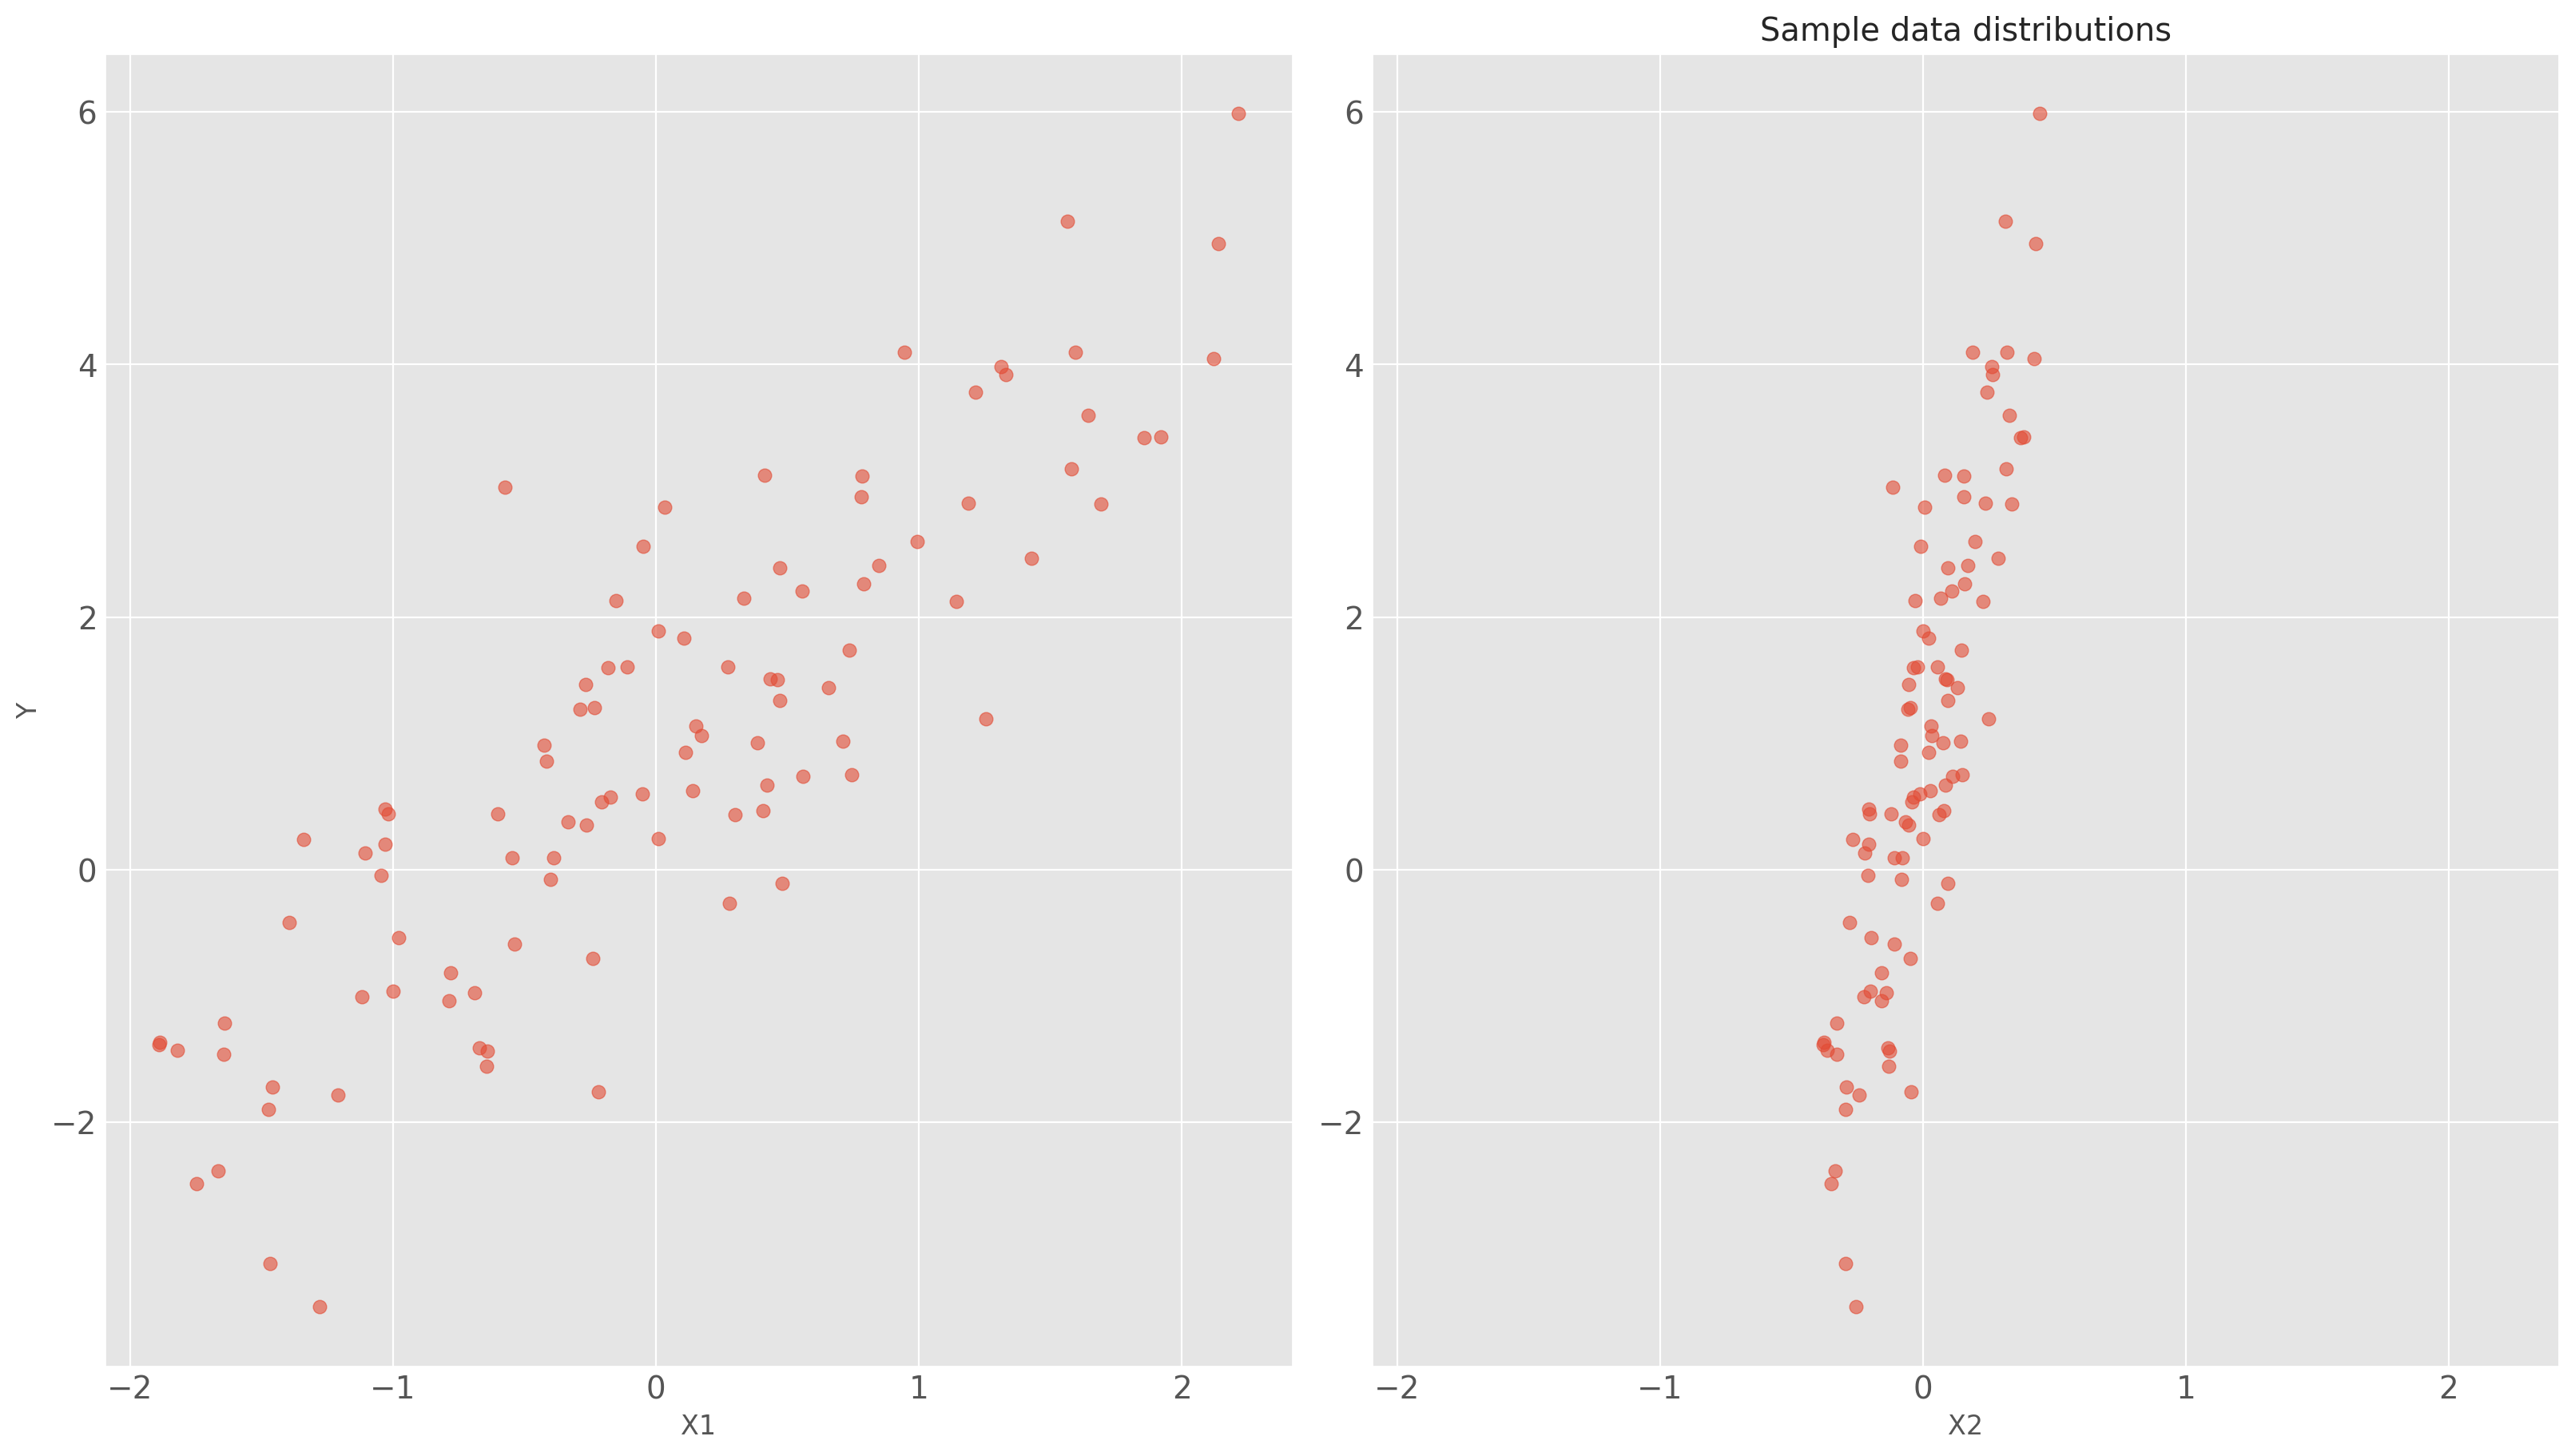

In [28]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16, 9))
plt.title('Sample data distributions')
axes[0].scatter(X_1, Y, alpha=0.6)
axes[1].scatter(X_2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [87]:
my_model = pm.Model()

with my_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X_1.to_py() + beta[1] * X_2.to_py()

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [88]:
with my_model:
    idata = pm.sample()

In [48]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [50]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[1.02886793, 1.02778792, 1.0591044 , 0.8607074 , 1.05051427],
       [0.94294194, 1.10502615, 0.88189628, 0.97423272, 0.97696964],
       [0.88327965, 0.85181816, 0.85181816, 1.15633664, 0.78300884],
       [0.89991464, 0.98388317, 0.93358857, 0.95059125, 0.91180289]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4

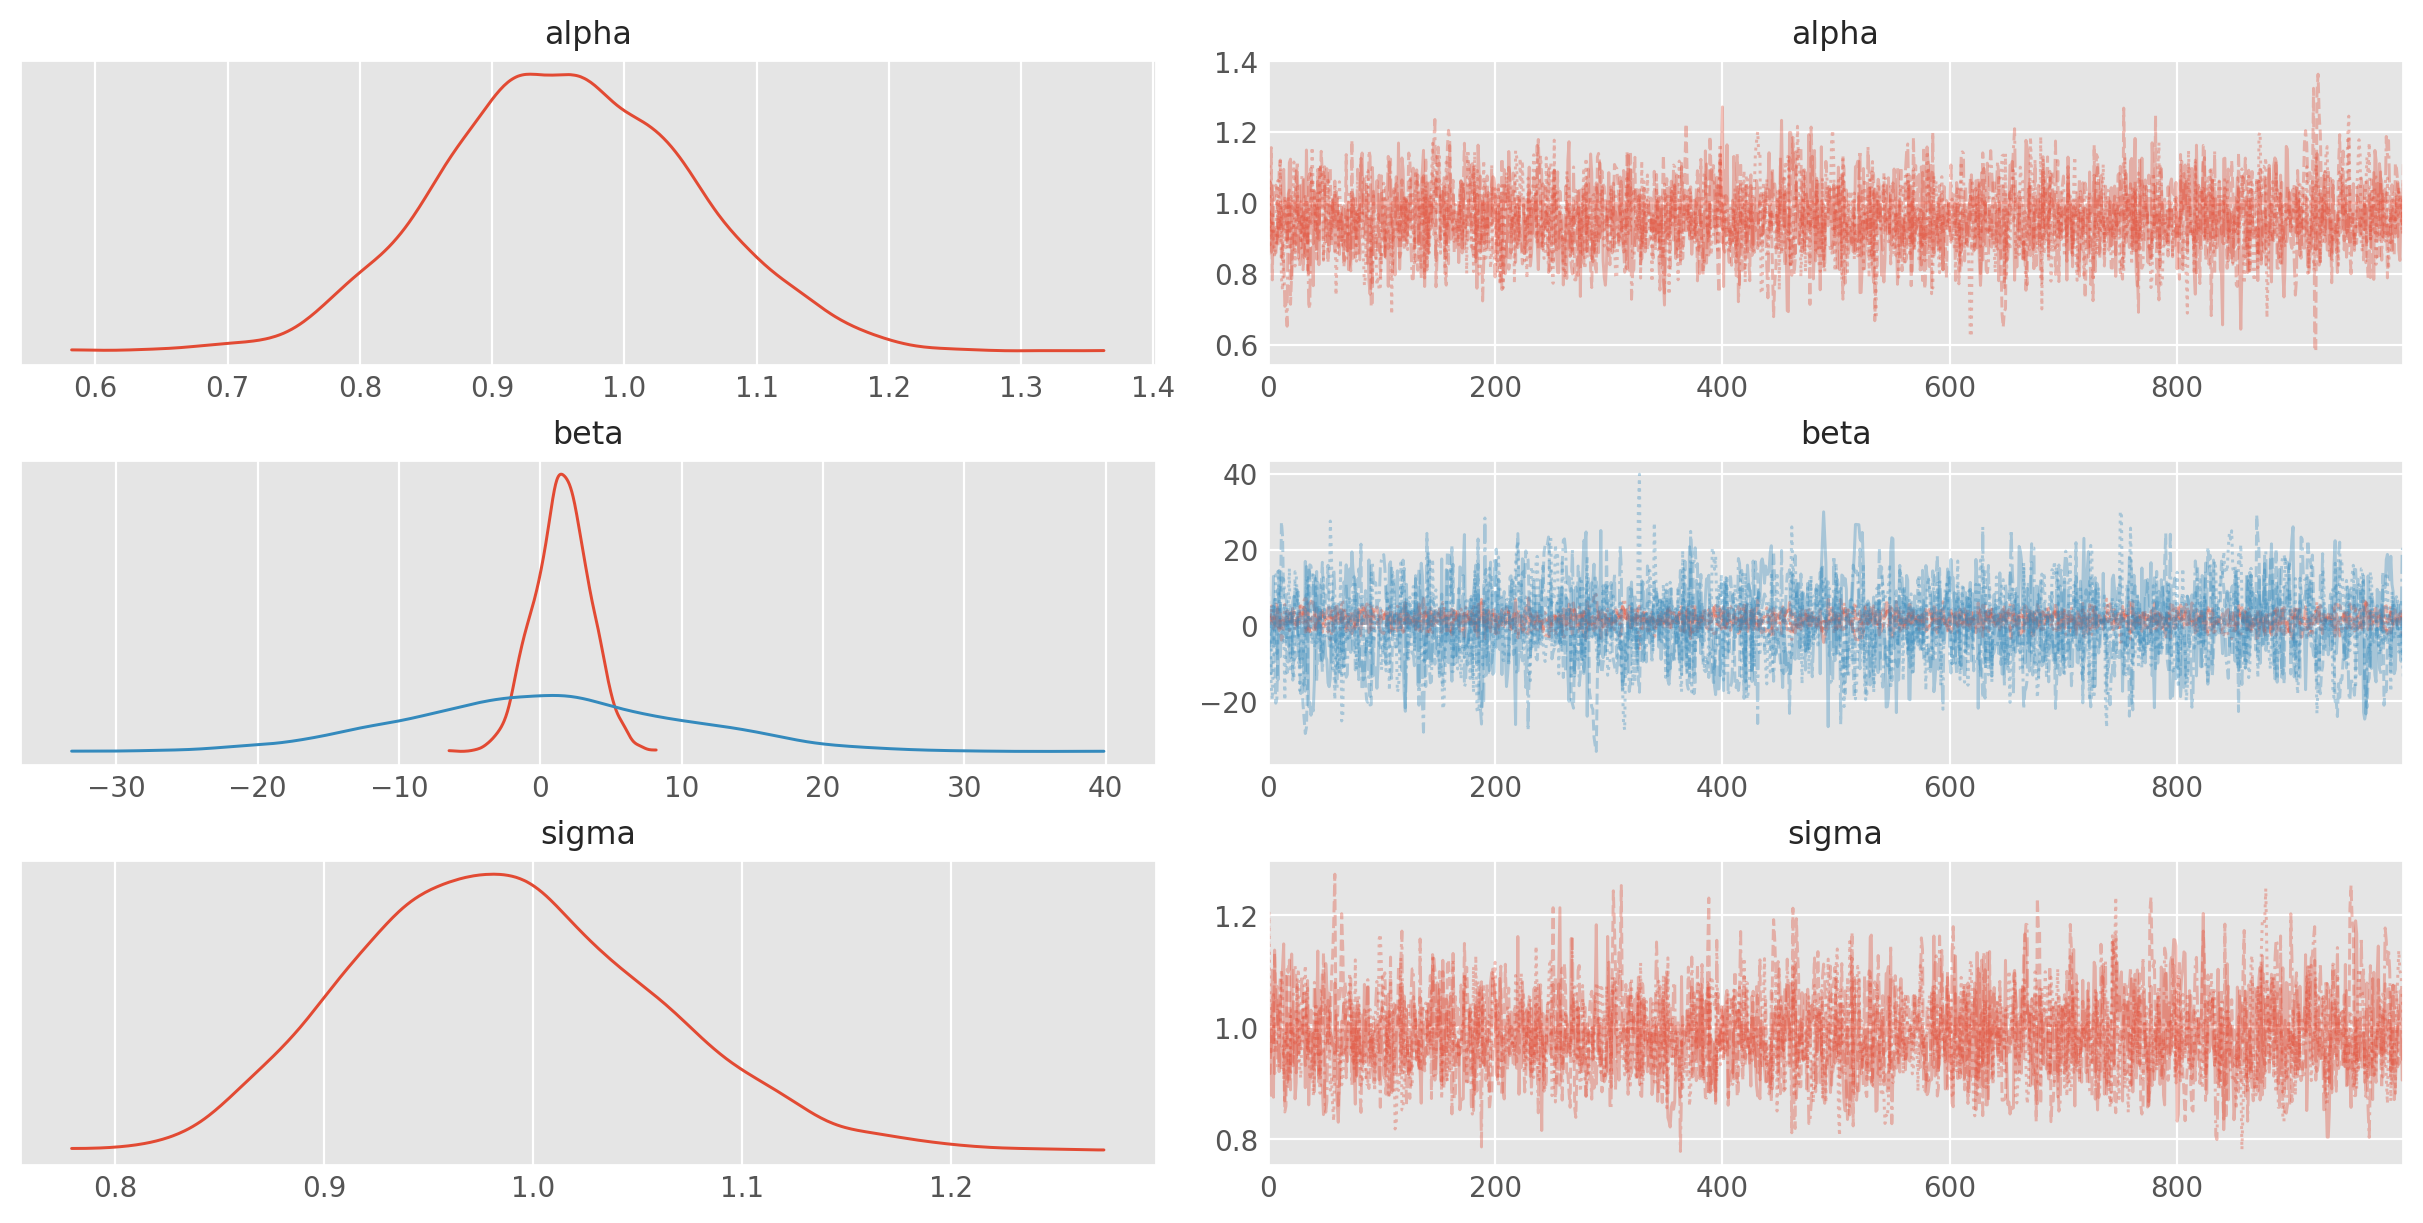

In [51]:
az.plot_trace(idata, combined=True);

In [52]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.96,0.10,0.78,1.13,0.00,0.00,3146.17,2533.98,1.0
beta[0],1.56,1.96,-2.17,5.09,0.05,0.04,1427.37,1792.00,1.0
beta[1],0.27,9.76,-18.00,18.34,0.26,0.18,1420.83,1834.80,1.0
sigma,0.99,0.07,0.85,1.12,0.00,0.00,2229.77,1958.80,1.0


### 2nd sample: Geometric distribution

In [53]:
df

,Day0,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,Day9,...,Day39,Day40,Day41,Day42,Day43,Day44,Day45,Day46,Day47,segment
0,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B
1,1,1,1,1,1,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B
2,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B
3,1,1,1,1,1,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B
4,1,1,1,1,1,1,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A
996,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A
997,1,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A
998,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,A


In [70]:
df['segment_id'] = pd.Categorical(df['segment']).codes

In [77]:
df_train, df_test = train_test_split(df.loc[:, df.columns != 'segment'], test_size=0.3, random_state=1)

In [78]:
df_train

,Day0,Day1,Day2,Day3,Day4,Day5,Day6,Day7,Day8,Day9,...,Day39,Day40,Day41,Day42,Day43,Day44,Day45,Day46,Day47,segment_id
731,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
716,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
640,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
804,1,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
737,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
72,1,1,1,1,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
908,1,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
235,1,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [79]:
X_train, X_test = df_train['segment_id'], df_test['segment_id']
y_train, y_test = df_train.sum(axis=1).astype('int'), df_test.sum(axis=1).astype('int')
# X_train = X_train.apply(lambda r: 1 if r=='B' else 0)
# X_test = X_test.apply(lambda r: 1 if r=='B' else 0)

In [83]:
X_train

731    0
716    0
640    0
804    0
737    0
      ..
767    0
72     1
908    0
235    0
37     1
Name: segment_id, Length: 700, dtype: int8

In [91]:
model = pm.Model()

with model:
    alpha = pm.HalfNormal('alpha', sigma=100, shape=(2,))
    beta = pm.HalfNormal('beta', sigma=100, shape=(2,))
    tscale = pm.Cauchy('tscale', alpha=0., beta=0.05)
    
    theta = pm.Beta('theta', alpha[X_train], beta) + tscale
    obs = pm.Geometric('obs', theta, observed=y_train)


In [92]:
with model:
    idata = pm.sample()

ERROR:aesara.graph.opt:Optimization failure due to: constant_folding
ERROR:aesara.graph.opt:node: Elemwise{add,no_inplace}(TensorConstant{(700,) of ..0000000004}, TensorConstant{(2,) of 10..0000000004})
ERROR:aesara.graph.opt:TRACEBACK:
ERROR:aesara.graph.opt:Traceback (most recent call last):
  File "/usr/local/google/home/yukoga/.pyenv/versions/3.10.6/lib/python3.10/site-packages/aesara/graph/opt.py", line 1861, in process_node
    replacements = lopt.transform(fgraph, node)
  File "/usr/local/google/home/yukoga/.pyenv/versions/3.10.6/lib/python3.10/site-packages/aesara/graph/opt.py", line 1066, in transform
    return self.fn(fgraph, node)
  File "/usr/local/google/home/yukoga/.pyenv/versions/3.10.6/lib/python3.10/site-packages/aesara/tensor/basic_opt.py", line 2785, in constant_folding
    required = thunk()
  File "/usr/local/google/home/yukoga/.pyenv/versions/3.10.6/lib/python3.10/site-packages/aesara/link/c/op.py", line 103, in rval
    thunk()
  File "/usr/local/google/home/yuk

KeyboardInterrupt: 